# Libraries and Configurations

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

import warnings
warnings.filterwarnings("ignore")

TensorFlow Version 2.6.4


In [5]:
image_size = 224
batch_size = 16
n_classes = 3
EPOCHS = 30

train_path = '/kaggle/input/pavement-crack-datasetinfrared-only/train'

classes = {1 : "High Crack",
           2 : "Low Crack",
           3 : "Medium Crack",
           4 : "No Crack"}

# Data Augmentations

In [31]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    # if p_pixel_1 >= .4:
    #     image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    # if p_pixel_2 >= .4:
    #     image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    # if p_pixel_3 >= .4:
    #     image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

# Data Generator

In [32]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)


# set as training data

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    ) 

# same directory as training data

valid_gen  = test_datagen.flow_from_directory(
    "/kaggle/input/pavement-crack-datasetinfrared-only/test",
    target_size=(224, 224),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical'
    )

Found 1855 images belonging to 4 classes.
Found 461 images belonging to 4 classes.


# Sample Image Visualization

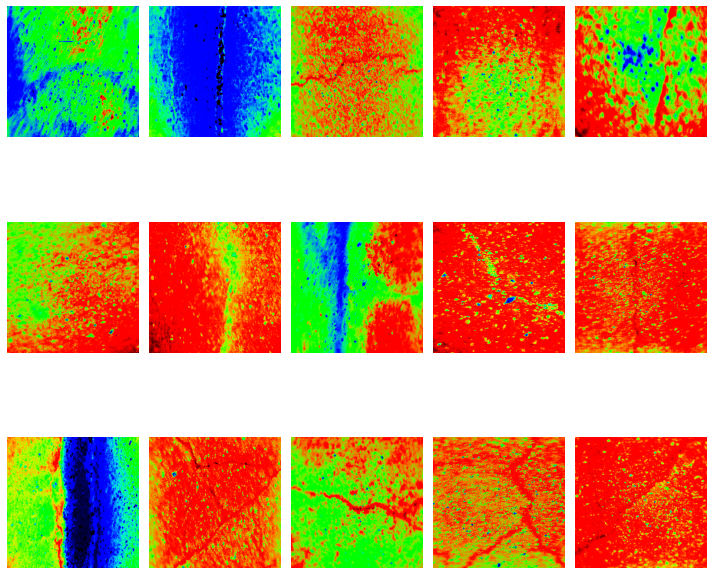

In [33]:
warnings.filterwarnings("ignore")

images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

# Building the Model

In [34]:
!pip install vit_keras

  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=6cff2e8546df2ee65d3ed6aaa9d25eba9b1f516c5704bcd6f12109e21935e711
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


# 1 - ViT B16 Model

In [35]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 4)

347512832/347502902 [==============================] - 3s 0us/step


In [37]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

## Visualizing Attention Maps of Sample Test Image

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


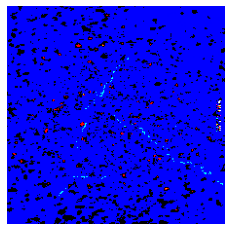

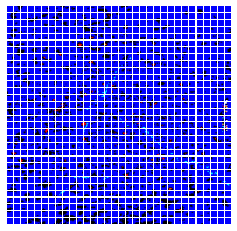

In [38]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

## ViT Model Architecture

In [41]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.Dense(4, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b16 (Functional)         (None, 768)               85798656  
_________________________________________________________________
flatten_1 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 768)               3072      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               98432     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)         

## Training the Model

In [42]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 15, restore_best_weights = True, verbose = 1)

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
115/115 [==============================] - 128s 756ms/step - loss: 1.2583 - accuracy: 0.5095 - val_loss: 1.1746 - val_accuracy: 0.5603
Epoch 2/30
115/115 [==============================] - 70s 608ms/step - loss: 1.0260 - accuracy: 0.7009 - val_loss: 1.1565 - val_accuracy: 0.5603
Epoch 3/30
115/115 [==============================] - 70s 606ms/step - loss: 0.9324 - accuracy: 0.7781 - val_loss: 1.1931 - val_accuracy: 0.5804
Epoch 4/30
115/115 [==============================] - 70s 605ms/step - loss: 0.8840 - accuracy: 0.8140 - val_loss: 1.0552 - val_accuracy: 0.6763
Epoch 5/30
115/115 [==============================] - 70s 612ms/step - loss: 0.8508 - accuracy: 0.8287 - val_loss: 1.0878 - val_accuracy: 0.6607
Epoch 6/30
115/115 [==============================] - 70s 605ms/step - loss: 0.8329 - accuracy: 0.8407 - val_loss: 0.9854 - val_accuracy: 0.7455
Epoch 7/30
115/115 [==============================] - 70s 608ms/step - loss: 0.8041 - accuracy: 0.8673 - val_loss: 0.9169 - val_a

In [43]:
# Save The Model

model.save('ViT_model.h5')

## ViT Model Result

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       121
           1       0.84      0.87      0.85       124
           2       0.68      0.65      0.66       124
           3       0.97      0.96      0.96        92

    accuracy                           0.82       461
   macro avg       0.82      0.82      0.82       461
weighted avg       0.81      0.82      0.81       461



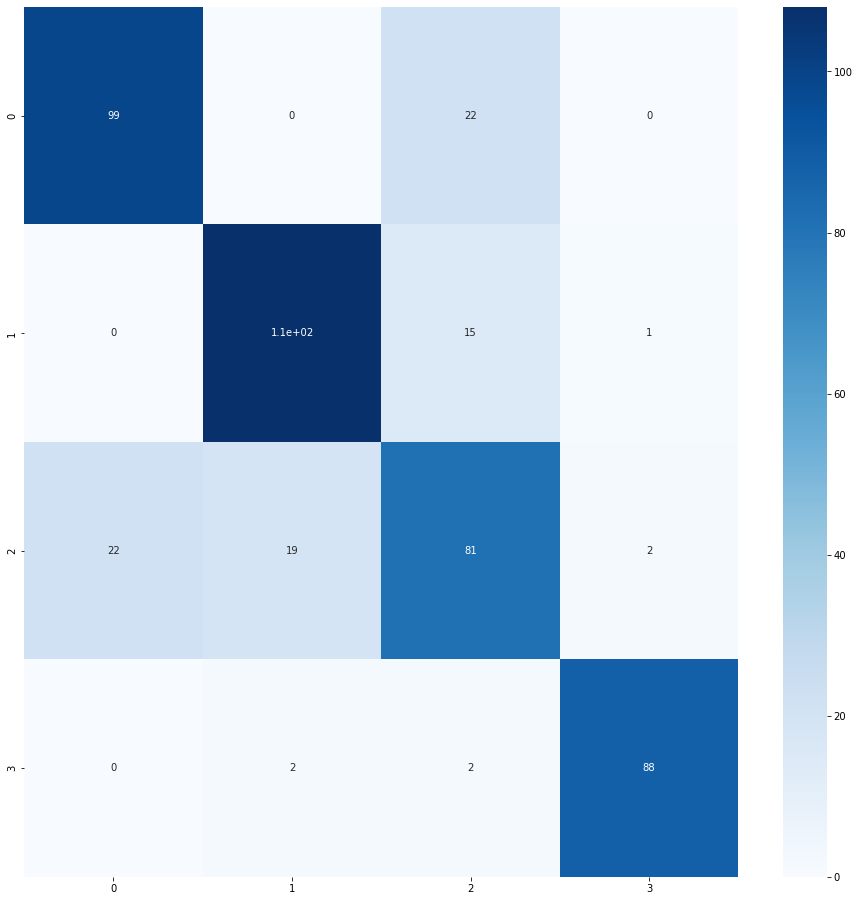

In [44]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

In [45]:
model.evaluate(valid_gen)

29/29 [==============================] - 5s 156ms/step - loss: 0.8906 - accuracy: 0.8156


[0.8906439542770386, 0.8156182169914246]

# 2 - ResNet50


In [55]:
model2 = tf.keras.Sequential()

base1= tf.keras.applications.ResNet50V2(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=4,
                   weights='imagenet')

model2.add(base1)

model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(128, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(64, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(32, activation = tfa.activations.gelu))
model2.add(tf.keras.layers.Dense(4, 'softmax'))

for layer in base1.layers:
    layer.trainable = False   

model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
flatten_6 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_24 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)               

## Training The Model


In [56]:
model2.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

history = model2.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
115/115 [==============================] - 36s 281ms/step - loss: 1.2918 - accuracy: 0.5084 - val_loss: 1.1641 - val_accuracy: 0.6362
Epoch 2/30
115/115 [==============================] - 31s 271ms/step - loss: 1.1255 - accuracy: 0.6161 - val_loss: 1.0899 - val_accuracy: 0.6942
Epoch 3/30
115/115 [==============================] - 32s 275ms/step - loss: 1.0732 - accuracy: 0.6688 - val_loss: 1.0489 - val_accuracy: 0.7254
Epoch 4/30
115/115 [==============================] - 32s 278ms/step - loss: 1.0472 - accuracy: 0.6922 - val_loss: 1.0374 - val_accuracy: 0.7254
Epoch 5/30
115/115 [==============================] - 32s 276ms/step - loss: 1.0391 - accuracy: 0.6939 - val_loss: 1.0098 - val_accuracy: 0.7344
Epoch 6/30
115/115 [==============================] - 32s 276ms/step - loss: 1.0299 - accuracy: 0.7031 - val_loss: 0.9939 - val_accuracy: 0.7478
Epoch 7/30
115/115 [==============================] - 31s 271ms/step - loss: 1.0121 - accuracy: 0.7145 - val_loss: 0.9845 - val_ac

## Model Result

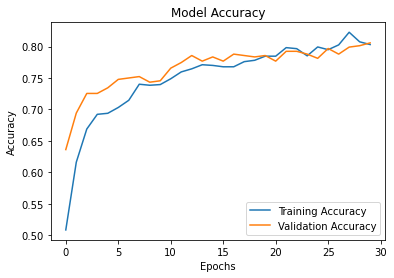

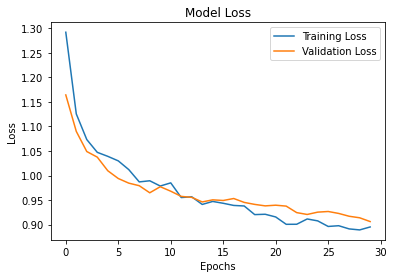

In [57]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       121
           1       0.87      0.94      0.90       124
           2       0.70      0.59      0.64       124
           3       0.89      0.93      0.91        92

    accuracy                           0.81       461
   macro avg       0.81      0.82      0.81       461
weighted avg       0.80      0.81      0.80       461



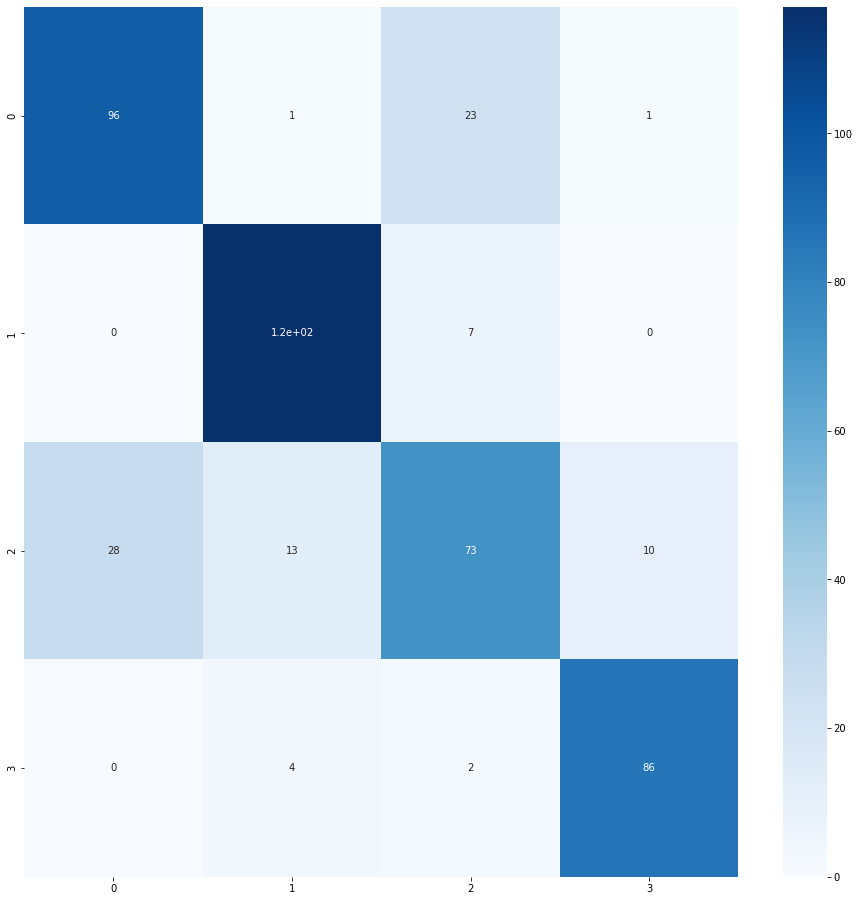

In [58]:
predicted_classes = np.argmax(model2.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

# 3 - VGG19

In [59]:
model3 = tf.keras.Sequential()

base2= tf.keras.applications.VGG19(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=4,
                   weights='imagenet')

model3.add(base2)

model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dense(128, activation = tfa.activations.gelu))
model3.add(tf.keras.layers.BatchNormalization())
model3.add(tf.keras.layers.Dense(64, activation = tfa.activations.gelu))
model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(32, activation = tfa.activations.gelu))
model3.add(tf.keras.layers.Dense(4, 'softmax'))

for layer in base2.layers:
    layer.trainable = False   

model3.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 512)               2048      
_________________________________________________________________
dense_28 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

## Training The Model

In [60]:
model3.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

history = model3.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
115/115 [==============================] - 37s 298ms/step - loss: 1.2975 - accuracy: 0.4753 - val_loss: 1.3571 - val_accuracy: 0.3214
Epoch 2/30
115/115 [==============================] - 34s 294ms/step - loss: 1.1385 - accuracy: 0.6063 - val_loss: 1.3191 - val_accuracy: 0.3951
Epoch 3/30
115/115 [==============================] - 34s 292ms/step - loss: 1.0992 - accuracy: 0.6580 - val_loss: 1.2927 - val_accuracy: 0.4509
Epoch 4/30
115/115 [==============================] - 33s 289ms/step - loss: 1.0624 - accuracy: 0.6824 - val_loss: 1.3154 - val_accuracy: 0.3929
Epoch 5/30
115/115 [==============================] - 33s 288ms/step - loss: 1.0470 - accuracy: 0.6977 - val_loss: 1.3571 - val_accuracy: 0.3750
Epoch 6/30
115/115 [==============================] - 33s 291ms/step - loss: 1.0485 - accuracy: 0.6813 - val_loss: 1.3676 - val_accuracy: 0.4129
Epoch 7/30
115/115 [==============================] - 34s 292ms/step - loss: 1.0282 - accuracy: 0.7085 - val_loss: 1.3196 - val_ac

## Model Result

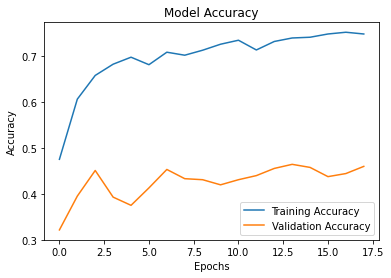

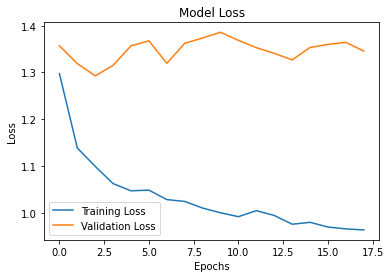

In [61]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4 - InceptionV3

In [64]:
model4 = tf.keras.Sequential()

base3= tf.keras.applications.inception_v3.InceptionV3(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   classes=4,
                   weights='imagenet')

model4.add(base3)

model4.add(tf.keras.layers.Flatten())
model4.add(tf.keras.layers.BatchNormalization())
model4.add(tf.keras.layers.Dense(128, activation = tfa.activations.gelu))
model4.add(tf.keras.layers.BatchNormalization())
model4.add(tf.keras.layers.Dense(64, activation = tfa.activations.gelu))
model4.add(tf.keras.layers.Dropout(0.5))
model4.add(tf.keras.layers.Dense(32, activation = tfa.activations.gelu))
model4.add(tf.keras.layers.Dense(4, 'softmax'))

for layer in base3.layers:
    layer.trainable = False   

model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_206 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_36 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_207 (Bat (None, 128)               512       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

## Training The Model


In [65]:
model4.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

history = model4.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
115/115 [==============================] - 37s 276ms/step - loss: 1.2980 - accuracy: 0.5128 - val_loss: 1.1558 - val_accuracy: 0.5893
Epoch 2/30
115/115 [==============================] - 31s 268ms/step - loss: 1.1102 - accuracy: 0.6291 - val_loss: 1.0686 - val_accuracy: 0.6830
Epoch 3/30
115/115 [==============================] - 31s 273ms/step - loss: 1.0781 - accuracy: 0.6591 - val_loss: 1.0270 - val_accuracy: 0.6964
Epoch 4/30
115/115 [==============================] - 31s 267ms/step - loss: 1.0635 - accuracy: 0.6688 - val_loss: 1.0031 - val_accuracy: 0.7076
Epoch 5/30
115/115 [==============================] - 31s 269ms/step - loss: 1.0283 - accuracy: 0.7031 - val_loss: 0.9739 - val_accuracy: 0.7321
Epoch 6/30
115/115 [==============================] - 31s 266ms/step - loss: 1.0143 - accuracy: 0.7151 - val_loss: 0.9812 - val_accuracy: 0.7321
Epoch 7/30
115/115 [==============================] - 31s 268ms/step - loss: 1.0105 - accuracy: 0.7069 - val_loss: 0.9713 - val_ac

##  Model Result

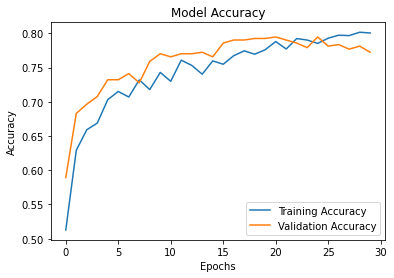

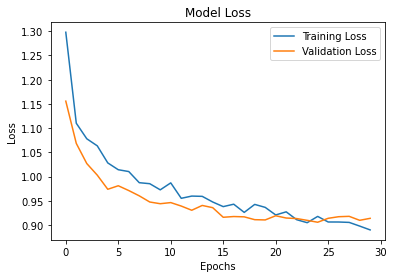

In [66]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       121
           1       0.96      0.77      0.85       124
           2       0.62      0.63      0.63       124
           3       0.90      0.99      0.94        92

    accuracy                           0.78       461
   macro avg       0.80      0.79      0.79       461
weighted avg       0.79      0.78      0.78       461



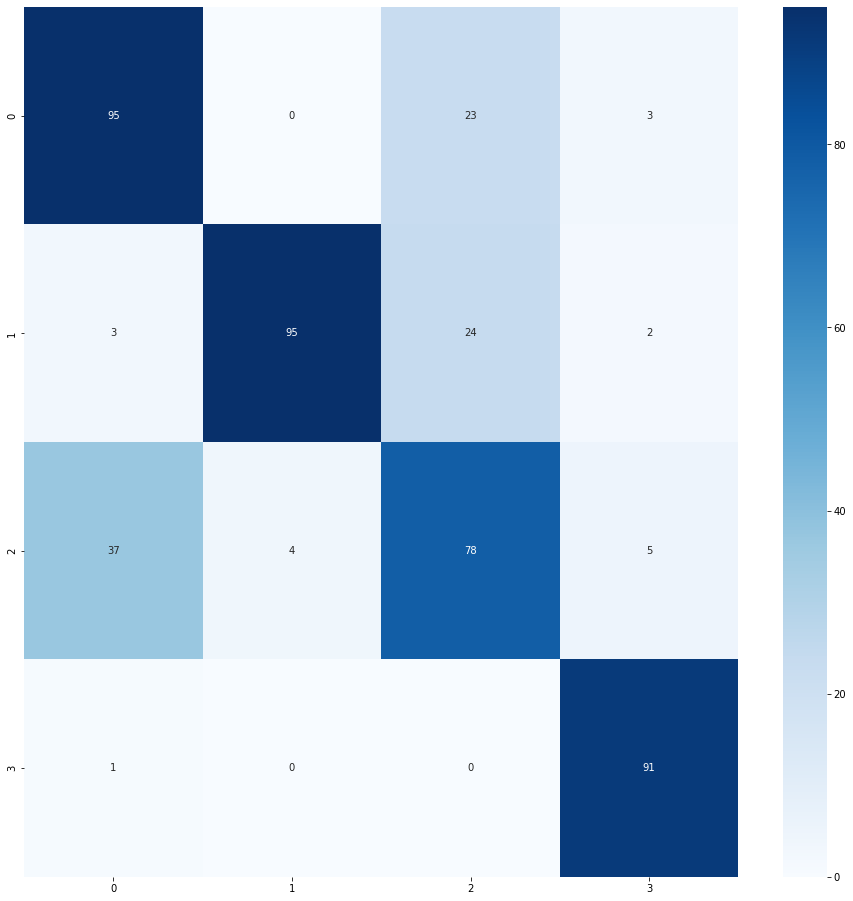

In [67]:
predicted_classes = np.argmax(model4.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))

In [68]:
model2.save("resnet_model.h5")

In [69]:
model3.save("vgg19.h5")

In [70]:
model4.save("inception_model.h5")

# 5 - EfficientNet-B0

In [76]:
model5 = tf.keras.Sequential()

base5= tf.keras.applications.EfficientNetB0(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   classes=4,
                   weights='imagenet')

model5.add(base5)

model5.add(tf.keras.layers.Flatten())
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.Dense(128, activation ="relu"))
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.Dense(64, activation = "relu"))
model5.add(tf.keras.layers.Dropout(0.5))
model5.add(tf.keras.layers.Dense(32, activation = "relu"))
model5.add(tf.keras.layers.Dense(4, 'softmax'))

for layer in base5.layers:
    layer.trainable = False   

model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_206 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_36 (Dense)             (None, 128)               262272    
_________________________________________________________________
batch_normalization_207 (Bat (None, 128)               512       
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

## Training the model

In [77]:
model5.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

history = model5.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/30
115/115 [==============================] - 40s 296ms/step - loss: 1.4786 - accuracy: 0.2926 - val_loss: 1.3873 - val_accuracy: 0.2768
Epoch 2/30
115/115 [==============================] - 30s 261ms/step - loss: 1.4124 - accuracy: 0.2964 - val_loss: 1.3918 - val_accuracy: 0.2768
Epoch 3/30
115/115 [==============================] - 30s 262ms/step - loss: 1.4032 - accuracy: 0.3051 - val_loss: 1.3879 - val_accuracy: 0.2768
Epoch 4/30
115/115 [==============================] - 30s 264ms/step - loss: 1.3893 - accuracy: 0.3002 - val_loss: 1.3778 - val_accuracy: 0.2768
Epoch 5/30
115/115 [==============================] - 31s 268ms/step - loss: 1.3664 - accuracy: 0.3241 - val_loss: 1.3698 - val_accuracy: 0.3929
Epoch 6/30
115/115 [==============================] - 31s 268ms/step - loss: 1.3646 - accuracy: 0.3235 - val_loss: 1.3742 - val_accuracy: 0.2701
Epoch 7/30
115/115 [==============================] - 30s 262ms/step - loss: 1.3615 - accuracy: 0.3350 - val_loss: 1.3932 - val_ac

## Model Result

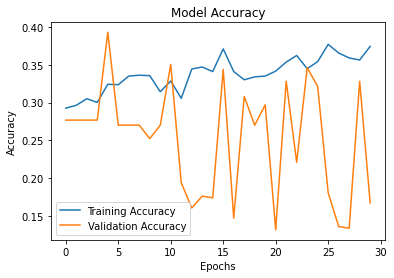

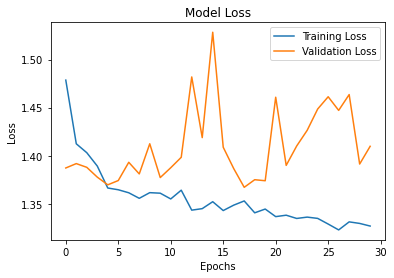

In [78]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.14      0.16      0.15       121
           1       0.00      0.00      0.00       124
           2       0.00      0.00      0.00       124
           3       0.21      0.74      0.33        92

    accuracy                           0.19       461
   macro avg       0.09      0.22      0.12       461
weighted avg       0.08      0.19      0.10       461



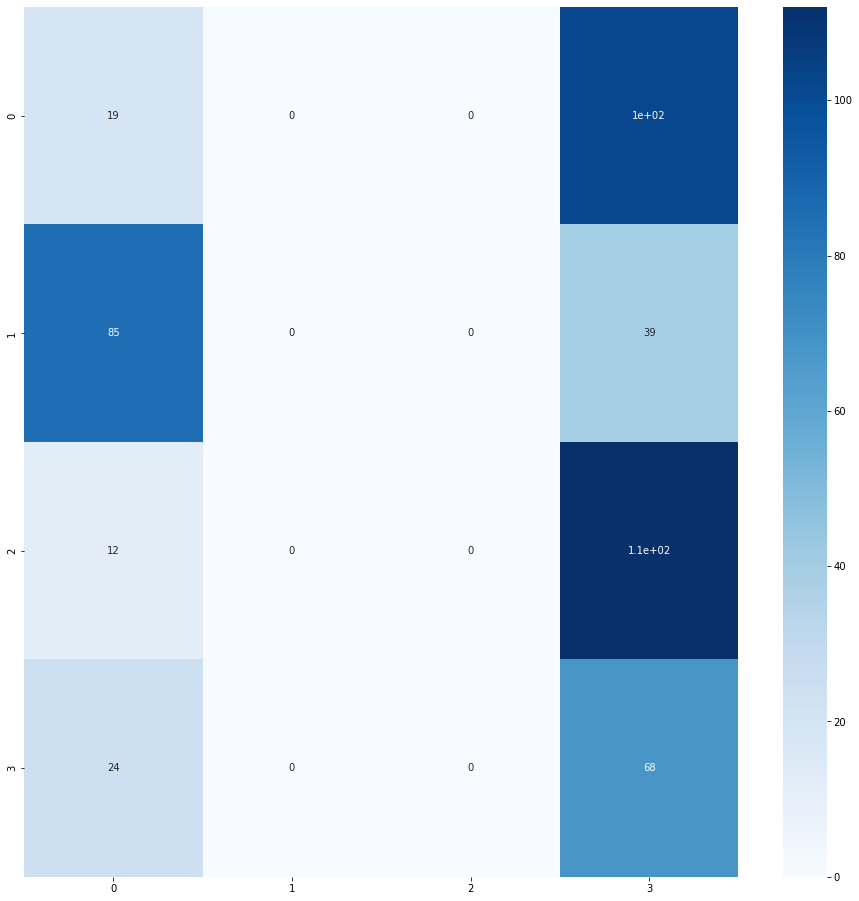

In [79]:
predicted_classes = np.argmax(model5.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))